#**Lab Assignment No 5: Local Feature Matching SIFT**

In [1]:
#Code Belongs to RAJAT KHANNA (2017UCS0050)
#IMPORTING LIBRARIES
%matplotlib inline
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import pandas as pd
import PIL
from PIL import Image
import numpy as np
import cv2
from PIL import Image, ImageOps
import sys
import random
import numpy
import math
import matplotlib.pyplot as plt
from matplotlib.image import imread
from IPython.core.debugger import set_trace

In [0]:
#LINKING COLAB TO DRIVE
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from google.colab import files

In [55]:
def im2single(im):
    im = im.astype(np.float32) / 255
    return im

def load_image(path):
    return im2single(cv2.imread(path))[:, :, ::-1]

In [0]:
#Importing Images
path1 = "/content/drive/My Drive/CVAssignment-5/921919841_a30df938f2_o.jpg"
path2 = "/content/drive/My Drive/CVAssignment-5/4191453057_c86028ce1f_o.jpg"

image1 = load_image(path1)
image2 = load_image(path2)

In [0]:
scale_factor = 0.5
feature_width = 16
image1 = cv2.resize(image1, (0, 0), fx=scale_factor, fy=scale_factor)
image2 = cv2.resize(image2, (0, 0), fx=scale_factor, fy=scale_factor)
image1_bw = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
image2_bw = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

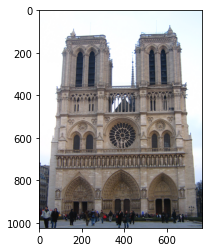

In [0]:
plt.imshow(image1)

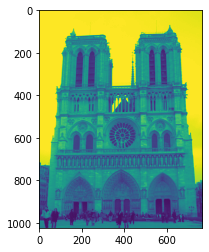

In [0]:
plt.imshow(image1_bw)

# ***Find Interest points in each image***

In [56]:
def ANMS (x , y, r, maximum):
    i = 0
    j = 0
    NewList = []
    while i < len(x):
        minimum = 1000000000000 
        FirstCoordinate, SecondCoordinate = x[i], y[i]
        while j < len(x):
            CompareCoordinate1, CompareCoordinate2 = x[j], y[j]
            if (FirstCoordinate != CompareCoordinate1 and SecondCoordinate != CompareCoordinate2) and r[i] < r[j]:
                distance = math.sqrt((CompareCoordinate1 - FirstCoordinate)**2 + (CompareCoordinate2 - SecondCoordinate)**2)
                if distance < minimum:
                    minimum = distance
            j = j + 1
        NewList.append([FirstCoordinate, SecondCoordinate, minimum])
        i = i + 1
        j = 0
    NewList.sort(key = lambda t: t[2])
    NewList = NewList[len(NewList)-maximum:len(NewList)]

    return NewList

def get_interest_points(image, feature_width):
    alpha = 0.04
    threshold = 10000
    XCorners = []
    YCorners = []
    RValues = []

    #Compute the size of the image.
    ImageRows = image.shape[0]
    ImageColumns = image.shape[1]

    #Use the soble filter to calculate the x and y derivative of the image
    Xderivative = cv2.Sobel(image, cv2.CV_64F,1,0,ksize=5)
    Yderivative = cv2.Sobel(image, cv2.CV_64F,0,1,ksize=5)

    Ixx = (Xderivative)*(Xderivative)
    Iyy = (Yderivative)*(Yderivative)
    Ixy = (Xderivative)*(Yderivative)

    for i in range(16, ImageRows - 16):
        for j in range(16, ImageColumns - 16):
            Ixx1 = Ixx[i-1:i+1, j-1:j+1]
            Iyy1 = Iyy[i-1:i+1, j-1:j+1]
            Ixy1 = Ixy[i-1:i+1, j-1:j+1]
            Ixxsum = Ixx1.sum()
            Iyysum = Iyy1.sum()
            Ixysum = Ixy1.sum()
            Determinant = Ixxsum*Iyysum - Ixysum**2
            Trace = Ixxsum + Iyysum
            R = Determinant - alpha*(Trace**2)
            if R > threshold:
                XCorners.append(j)
                YCorners.append(i)
                RValues.append(R)
    XCorners = np.asarray(XCorners)
    YCorners = np.asarray(YCorners)
    RValues = np.asarray(RValues)

    NewCorners = ANMS(XCorners, YCorners, RValues, 3025)
    NewCorners = np.asarray(NewCorners)

    #Return the x-y coordinates and cornerness score of the eligible corners.
    x = NewCorners[:,0]
    y = NewCorners[:,1]
    scales = NewCorners[:,2]

    return x,y, scales

def show_interest_points(img, X, Y):
    newImg = img.copy()
    for x, y in zip(X.astype(int), Y.astype(int)):
        cur_color = np.random.rand(3)
        newImg = cv2.circle(newImg, (x, y), 10, cur_color, -1, cv2.LINE_AA)

    return newImg

In [0]:
x1, y1, scales1= get_interest_points(image1_bw, feature_width)
x2, y2, scales2 = get_interest_points(image2_bw, feature_width)

In [0]:
# Visualize the interest points
c1 = show_interest_points(image1, x1, y1)
c2 = show_interest_points(image2, x2, y2)

3025 corners in image 1, 3025 corners in image 2


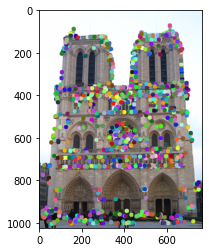

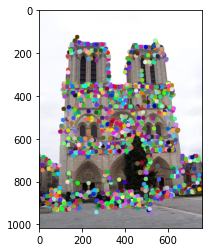

In [0]:
plt.figure(); plt.imshow(c1)
plt.savefig('NotreDame1.jpg')
files.download("NotreDame1.jpg") 
plt.figure(); plt.imshow(c2)
plt.savefig('NotreDame2.jpg')
files.download("NotreDame2.jpg") 
print('{:d} corners in image 1, {:d} corners in image 2'.format(len(x1), len(x2)))

# ***Create feature vectors at each interest point*** 

In [57]:
def get_features(image, x, y, feature_width):
  x = np.rint(x)
  x = x.astype(int)
  y = np.rint(y)
  y = y.astype(int)

  #Define a gaussian filter.
  cutoff_frequency = 10
  filter1 = cv2.getGaussianKernel(ksize=4,sigma=cutoff_frequency)
  filter1 = np.dot(filter1, filter1.T)
  image = cv2.filter2D(image, -1, filter1)
  ImageRows = image.shape[0]
  ImageColumns = image.shape[1]
  Xcoordinates = len(x)
  Ycoordinates = len(y)
  FeatureVectorIn = np.ones((Xcoordinates,128))
  NormalizedFeature = np.zeros((Xcoordinates,128))

  #loop over the corners generated by Harris
  for i in range(Xcoordinates):
    #Extract a 16X16 window centered at the corner pixel
    temp1 = int(x[i])
    temp2 = int(y[i])
    Window = image[temp2-8:temp2 + 8, temp1-8:temp1 + 8]
    WindowRows = Window.shape[0]
    WindowColumns = Window.shape[1]
    for p in range(4):
      for q in range(4):
        WindowCut = Window[p*4:p*4 +4,q*4: q*4+4]
        NewWindowCut = cv2.copyMakeBorder(WindowCut, 1, 1, 1, 1, cv2.BORDER_REFLECT)
        Magnitude = np.zeros((4,4))
        Orientation = np.zeros((4,4))

        for r in range(WindowCut.shape[0]):
          for s in range(WindowCut.shape[1]):
            Magnitude[r,s] = math.sqrt((NewWindowCut[r+1,s] - NewWindowCut[r-1,s])**2 + (NewWindowCut[r,s+1] - NewWindowCut[r,s-1])**2)
            Orientation[r,s] = np.arctan2((NewWindowCut[r+1,s] - NewWindowCut[r-1,s]),(NewWindowCut[r,s+1] - NewWindowCut[r,s-1]))

        Magnitude = Magnitude
        OrientationNew = Orientation*(180/(math.pi))
        hist, edges = np.histogram(OrientationNew, bins = 8, range = (-180,180), weights = Magnitude)
        for t in range(8):
          l = t+p*32+q*8
          FeatureVectorIn[i,l] = hist[t]

  for a in range(FeatureVectorIn.shape[0]):
    sum1 = 0
    for b in range(FeatureVectorIn.shape[1]):
      sum1 = sum1 + (FeatureVectorIn[a][b])*(FeatureVectorIn[a][b])
    sum1 = math.sqrt(sum1)

    for c in range(FeatureVectorIn.shape[1]):
      NormalizedFeature[a][c] = FeatureVectorIn[a][c]/sum1

  fv = NormalizedFeature

  return fv

In [0]:
image1_features = get_features(image1_bw, x1, y1, feature_width)
image2_features = get_features(image2_bw, x2, y2, feature_width)

In [0]:
print(image1_features)

[[0.         0.08862312 0.12278028 ... 0.04111843 0.         0.11997906]
 [0.         0.04626406 0.10119059 ... 0.10974823 0.         0.08462564]
 [0.         0.07845212 0.0737156  ... 0.08131838 0.03080907 0.        ]
 ...
 [0.02947879 0.         0.         ... 0.05068695 0.01837127 0.00656604]
 [0.02330348 0.         0.         ... 0.02395227 0.07456616 0.00730358]
 [0.06131806 0.         0.         ... 0.         0.         0.09725152]]


# ***Match features*** 

In [58]:
def match_features(features1, features2, x1, y1, x2, y2):
    Distance = np.zeros((features1.shape[0], features2.shape[0]))
    Value = []
    Hitx = []
    Hity = []
    for x in range(features1.shape[0]):
        for y in range(features2.shape[0]):
            #Extract the feature vector of image1 &image2
            ExtractedRow1 = features1[[x],:]
            ExtractedRow2 = features2[[y],:]
            #Calculate the Euclidean distance between the feature vectors and sort.
            SubtractedRow = ExtractedRow1 - ExtractedRow2
            Square = SubtractedRow*SubtractedRow
            Sum = Square.sum()
            Sum = math.sqrt(Sum)
            Distance[x,y] = Sum

        IndexPosition = np.argsort(Distance[x,:])
        #Take the two smallest distances between the feature vectors
        d1 = IndexPosition[0]
        d2 = IndexPosition[1]
        Position1 = Distance[x,d1]
        Position2 = Distance[x,d2]
        ratio = Position1/Position2
        if ratio<0.8:
            Hitx.append(x)
            Hity.append(d1)
            Value.append(Position1)

    Xposition = np.asarray(Hitx)
    Yposition = np.asarray(Hity)
    matches = np.stack((Xposition,Yposition), axis = -1)
    confidences = np.asarray(Value)

    return matches, confidences

In [0]:
matches, confidences = match_features(image1_features, image2_features, x1, y1, x2, y2)
print('{:d} matches from {:d} corners'.format(len(matches), len(x1)))

163 matches from 3025 corners


# ***Visualization***

In [59]:
def hstack_images(imgA, imgB):
    Height = max(imgA.shape[0], imgB.shape[0])
    Width  = imgA.shape[1] + imgB.shape[1]
    newImg = np.zeros((Height, Width, 3), dtype=imgA.dtype)
    newImg[:imgA.shape[0], :imgA.shape[1], :] = imgA
    newImg[:imgB.shape[0], imgA.shape[1]:, :] = imgB
    return newImg
    
def show_correspondence_circles(imgA, imgB, X1, Y1, X2, Y2):
    newImg = hstack_images(imgA, imgB)
    shiftX = imgA.shape[1]
    X1 = X1.astype(np.int)
    Y1 = Y1.astype(np.int)
    X2 = X2.astype(np.int)
    Y2 = Y2.astype(np.int)
    for x1, y1, x2, y2 in zip(X1, Y1, X2, Y2):
        cur_color = np.random.rand(3)
        green = (0, 1, 0)
        newImg = cv2.circle(newImg, (x1, y1), 10, cur_color, -1, cv2.LINE_AA)
        newImg = cv2.circle(newImg, (x1, y1), 10, green, 2, cv2.LINE_AA)
        newImg = cv2.circle(newImg, (x2+shiftX, y2), 10, cur_color, -1, cv2.LINE_AA)
        newImg = cv2.circle(newImg, (x2+shiftX, y2), 10, green, 2, cv2.LINE_AA)

    return newImg

def show_correspondence_lines(imgA, imgB, X1, Y1, X2, Y2, line_colors=None):
    newImg = hstack_images(imgA, imgB)
    shiftX = imgA.shape[1]
    X1 = X1.astype(np.int)
    Y1 = Y1.astype(np.int)
    X2 = X2.astype(np.int)
    Y2 = Y2.astype(np.int)

    dot_colors = np.random.rand(len(X1), 3)
    if line_colors is None:
        line_colors = dot_colors

    for x1, y1, x2, y2, dot_color, line_color in zip(X1, Y1, X2, Y2, dot_colors,
            line_colors):
        newImg = cv2.circle(newImg, (x1, y1), 5, dot_color, -1)
        newImg = cv2.circle(newImg, (x2+shiftX, y2), 5, dot_color, -1)
        newImg = cv2.line(newImg, (x1, y1), (x2+shiftX, y2), line_color, 2,cv2.LINE_AA)
    return newImg

In [0]:
num_pts_to_visualize = 100

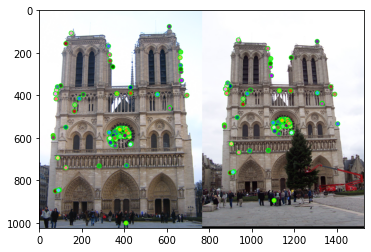

In [0]:
c1 = show_correspondence_circles(image1, image2,x1[matches[:num_pts_to_visualize, 0]], y1[matches[:num_pts_to_visualize, 0]],x2[matches[:num_pts_to_visualize, 1]], y2[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c1)
plt.savefig('NotreDameCircles.jpg')
files.download("NotreDameCircles.jpg") 

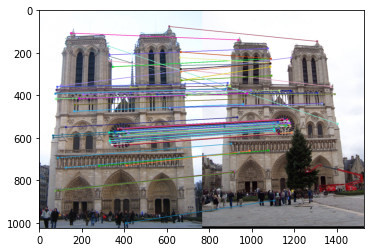

In [0]:
c2 = show_correspondence_lines(image1, image2,x1[matches[:num_pts_to_visualize, 0]], y1[matches[:num_pts_to_visualize, 0]],x2[matches[:num_pts_to_visualize, 1]], y2[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c2)
plt.savefig('NotreDameLines.jpg')
files.download("NotreDameLines.jpg") 

In [0]:
feature_width = 16
scale_factor = 0.5
#Taking all the Input Images in Train_Images List
#Resizing and converting them to GrayScale and Storing Them in Train_Images_bw list

import glob
Train_Images = []
Train_Images_bw = []
for img in glob.glob("/content/drive/My Drive/CVAssignment-5/Drive/TrainData/*.jpg"):
    image1 = load_image(img)
    image1 = cv2.resize(image1, (0, 0), fx=scale_factor, fy=scale_factor)
    image1_bw = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
    Train_Images.append(image1)
    Train_Images_bw.append(image1_bw)

In [0]:
#Taking all the Input Images in Test_Images List
#Resizing and converting them to GrayScale and Storing Them in Test_Images_bw list

Test_Images = []
Test_Images_bw = []
for img in glob.glob("/content/drive/My Drive/CVAssignment-5/Drive/TestData/*.jpg"):
    image1 = load_image(img)
    image1 = cv2.resize(image1, (0, 0), fx=scale_factor, fy=scale_factor)
    image1_bw = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
    Test_Images.append(image1)
    Test_Images_bw.append(image1_bw)

In [0]:
#Finding Interest Points of every Training Image and storing Them in InterestPointsTrain list
InterestPointsTrain = []
for image1_bw in Train_Images_bw:
    x1, y1, scales1 = get_interest_points(image1_bw, feature_width)
    c1 = show_interest_points(image1, x1, y1)
    InterestPointsTrain.append([x1, y1, scales1])

In [0]:
#Finding Interest Points of every Testing Image and storing Them in InterestPointsTest list
InterestPointsTest = []
for image1_bw in Train_Images_bw:
    x1, y1, scales1 = get_interest_points(image1_bw, feature_width)
    c1 = show_interest_points(image1, x1, y1)
    InterestPointsTest.append([x1, y1, scales1])

In [0]:
#Finding Image features of every Training Image and storing Them in ImageFeaturesTrain list
ImageFeaturesTrain = []
for image1_bw in InterestPointsTrain:
    image11_features = get_features(image11_bw, x11, y11, feature_width)
    ImageFeaturesTrain.append(image11_features)

In [0]:
#Finding Image features of every Testing Image and storing Them in ImageFeaturesTest list
ImageFeaturesTest = []
for image1_bw in InterestPointsTest:
    image11_features = get_features(image11_bw, x11, y11, feature_width)
    ImageFeaturesTrain.append(image11_features)

In [0]:
#Iterating over the Test Images Features
for [x1,y1,c1] in ImageFeaturesTest:
    currMatches = 0
    X2 = 0
    Y2 = 0
    #Iterating over Train Images Features & finding the best Match for the Test Image
    for [x2,y2,c2] in ImageFeaturesTrain:
        matches, confidences = match_features(image11_features, image22_features, x11, y11, x22, y22)
        #If number of match points are more, it means it has more closeness to the target Image
        #and hence updating our closest Image
        if(matches > currMatches):
            X2 = x2
            Y2 = y2
            matches = currMatches
    matches, confidences = match_features(image11_features, image22_features, x11, y11, x22, y22)
    #Outputing The Closest Match of the Current Image
    c11 = show_correspondence_circles(image11, image22,x11[matches[:num_pts_to_visualize, 0]], y11[matches[:num_pts_to_visualize, 0]],x22[matches[:num_pts_to_visualize, 1]], y22[matches[:num_pts_to_visualize, 1]])
    plt.figure(); plt.imshow(c11)

## Some Results of the Above Code

3025 corners in image 1, 3025 corners in image 2


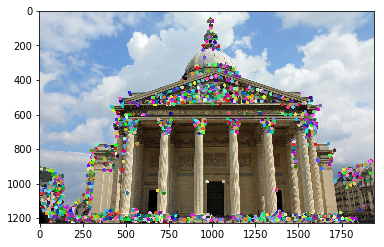

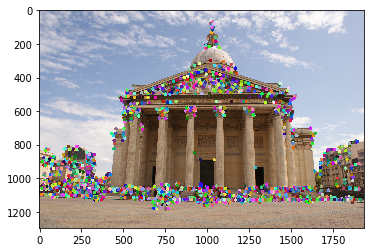

In [95]:
#PantheonParis Image
plt.figure(); plt.imshow(c11)
plt.savefig('PantheonParis1.jpg')
plt.figure(); plt.imshow(c22)
plt.savefig('PantheonParis2.jpg') 
print('{:d} corners in image 1, {:d} corners in image 2'.format(len(x11), len(x22)))

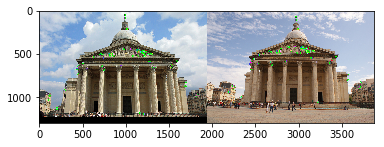

In [98]:
num_pts_to_visualize = 100
c11 = show_correspondence_circles(image11, image22,x11[matches[:num_pts_to_visualize, 0]], y11[matches[:num_pts_to_visualize, 0]],x22[matches[:num_pts_to_visualize, 1]], y22[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c11)
plt.savefig('PantheonParisCircles.jpg')

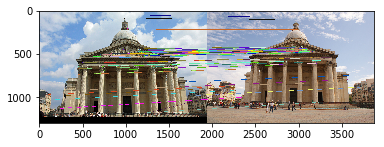

In [99]:
c22 = show_correspondence_lines(image11, image22,x11[matches[:num_pts_to_visualize, 0]], y11[matches[:num_pts_to_visualize, 0]],x22[matches[:num_pts_to_visualize, 1]], y22[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c22)
plt.savefig('PantheonParisLines.jpg')

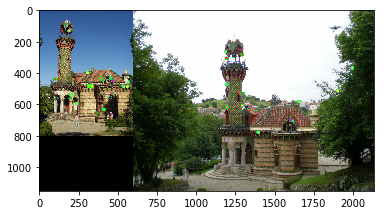

In [86]:
#CaprichoGaudi Image
num_pts_to_visualize = 100
c11 = show_correspondence_circles(image11, image22,x11[matches[:num_pts_to_visualize, 0]], y11[matches[:num_pts_to_visualize, 0]],x22[matches[:num_pts_to_visualize, 1]], y22[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c11)
plt.savefig('CaprichoGaudiCircles.jpg')

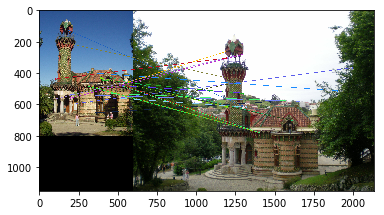

In [87]:
c22 = show_correspondence_lines(image11, image22,x11[matches[:num_pts_to_visualize, 0]], y11[matches[:num_pts_to_visualize, 0]],x22[matches[:num_pts_to_visualize, 1]], y22[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c22)
plt.savefig('CaprichoGaudiLines.jpg')

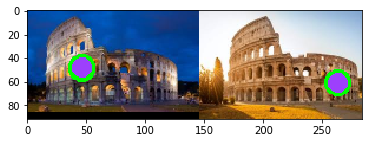

In [70]:
#Colosseum Image
num_pts_to_visualize = 100
c11 = show_correspondence_circles(image11, image22,x11[matches[:num_pts_to_visualize, 0]], y11[matches[:num_pts_to_visualize, 0]],x22[matches[:num_pts_to_visualize, 1]], y22[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c11)
plt.savefig('ColosseumCircles.jpg')

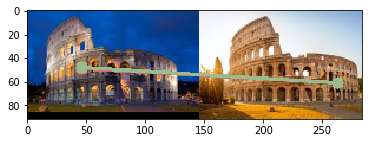

In [71]:
c22 = show_correspondence_lines(image11, image22,x11[matches[:num_pts_to_visualize, 0]], y11[matches[:num_pts_to_visualize, 0]],x22[matches[:num_pts_to_visualize, 1]], y22[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c22)
plt.savefig('ColosseumLines.jpg')

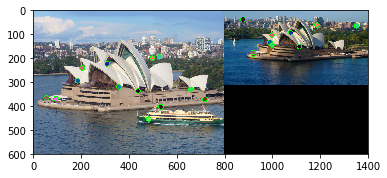

In [24]:
#OperaHouseSydney Image
num_pts_to_visualize = 100
c11 = show_correspondence_circles(image11, image22,x11[matches[:num_pts_to_visualize, 0]], y11[matches[:num_pts_to_visualize, 0]],x22[matches[:num_pts_to_visualize, 1]], y22[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c11)
plt.savefig('OperaHouseSydneyCircles.jpg')

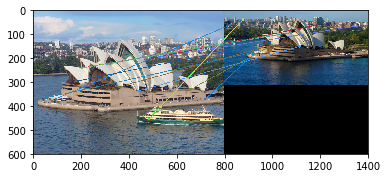

In [25]:
c22 = show_correspondence_lines(image11, image22,x11[matches[:num_pts_to_visualize, 0]], y11[matches[:num_pts_to_visualize, 0]],x22[matches[:num_pts_to_visualize, 1]], y22[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c22)
plt.savefig('OperaHouseSydneyLines.jpg')

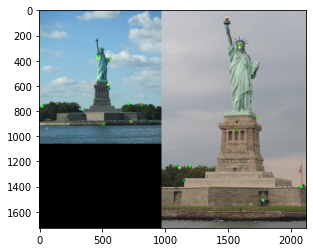

In [0]:
#Statueofliberty Image
c11 = show_correspondence_circles(image11, image22,x11[matches[:num_pts_to_visualize, 0]], y11[matches[:num_pts_to_visualize, 0]],x22[matches[:num_pts_to_visualize, 1]], y22[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c11)
plt.savefig('StatueoflibertyCircles.jpg')
files.download("StatueoflibertyCircles.jpg") 
plt.savefig('/content/drive/My Drive/CVAssignment-5/vis_circles.jpg', dpi=1000)

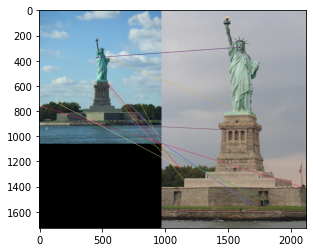

In [0]:
c22 = show_correspondence_lines(image11, image22,x11[matches[:num_pts_to_visualize, 0]], y11[matches[:num_pts_to_visualize, 0]],x22[matches[:num_pts_to_visualize, 1]], y22[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c22)
plt.savefig('StatueoflibertyLines.jpg')
files.download("StatueoflibertyLines.jpg") 
plt.savefig('/content/drive/My Drive/CVAssignment-5/vis_lines.jpg', dpi=1000)

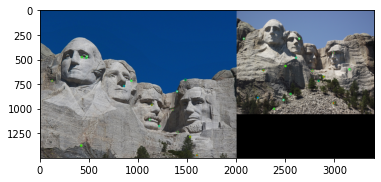

In [0]:
#MountRushmore Image
c11 = show_correspondence_circles(image11, image22,x11[matches[:num_pts_to_visualize, 0]], y11[matches[:num_pts_to_visualize, 0]],x22[matches[:num_pts_to_visualize, 1]], y22[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c11)
plt.savefig('MountRushmoreCircles.jpg')
files.download("MountRushmoreCircles.jpg") 
plt.savefig('/content/drive/My Drive/CVAssignment-5/vis_circles.jpg', dpi=1000)

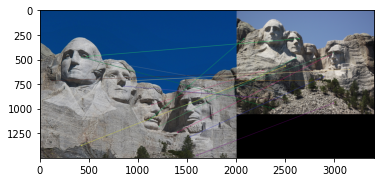

In [0]:
c22 = show_correspondence_lines(image11, image22,x11[matches[:num_pts_to_visualize, 0]], y11[matches[:num_pts_to_visualize, 0]],x22[matches[:num_pts_to_visualize, 1]], y22[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c22)
plt.savefig('MountRushmoreLines.jpg')
files.download("MountRushmoreLines.jpg") 
plt.savefig('/content/drive/My Drive/CVAssignment-5/vis_lines.jpg', dpi=1000)